I am using [18,393 Pitchfork Reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data) dataset from Kaggle. It presents more than 18,000 music reviews extracted from the music platform Pitchfork between 1999 and 2017. I trained a deep learning model with LSTM layers to predict the score of the music review.

### Preprocessing

In [1]:
import sqlite3
import pandas as pd

In [5]:
con = sqlite3.connect('database.sqlite') 

In [6]:
general = pd.read_sql('SELECT * FROM reviews', con)

In [7]:
review = pd.read_sql('SELECT * FROM content', con)

In [8]:
reviews = pd.merge(general, review, on = 'reviewid')

In [9]:
review_dataset = reviews[['score', 'content']]

In [ ]:
review_dataset.head()

,score,content
0,9.3,"“Trip-hop” eventually became a ’90s punchline,..."
1,7.9,"Eight years, five albums, and two EPs in, the ..."
2,7.3,Minneapolis’ Uranium Club seem to revel in bei...
3,9.0,Kleenex began with a crash. It transpired one ...
4,8.1,It is impossible to consider a given release b...


In [10]:
import tensorflow as tf 
import tensorflow_datasets as tfds

In order to have a classification model, I transform the score values into integer.

In [11]:
review_dataset['score'] = review_dataset['score'].apply(lambda x: int(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
review_dataset['score'].unique()

array([ 9,  7,  8,  5,  3,  6,  4, 10,  2,  1,  0])

In [ ]:
review_dataset.shape

(18401, 2)

I don't have enough capacity with my computer to process the 18401 reviews so I take a sample of 1000 reviews.

In [12]:
dataset_small = review_dataset.sample(1000)

In [13]:
# creation of the tensorflow dataset
tf_ds = tf.data.Dataset.from_tensor_slices((dataset_small["content"].values, dataset_small["score"].values))

In [14]:
# Randomization with shuffle 
tf_ds = tf_ds.shuffle(1000)

In [15]:
# Let's import the english language library from spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.6MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=0f7f702311e7d74b8438527838998d1da45e491ecaa8c031f95c814f3470250d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h66i3sx7/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [16]:
import en_core_web_md
nlp = en_core_web_md.load()

In [17]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [18]:
# Creation of a corpus of the text
corpus = ' '.join(dataset_small["content"].to_list())
len(corpus)

4028391

In [19]:
%%time
import time
nlp.max_length = len(corpus)
doc = nlp(corpus)

CPU times: user 1min 25s, sys: 5.97 s, total: 1min 31s
Wall time: 1min 31s


In [ ]:
#DataViz Worldcloud without STOP WORDS

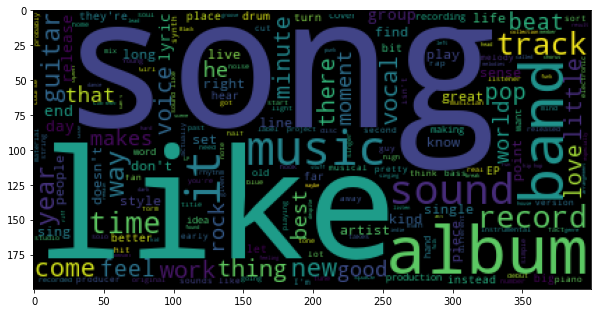

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wd = WordCloud(stopwords=STOP_WORDS)
cloud = wd.generate(doc.text)
plt.figure(figsize=(10,15), facecolor='white')
plt.imshow(cloud)

In [ ]:
#Let's add STOP WORDS to our list in order to withdraw words that are too many times said and clean our dataset
STOP_WORDS |= {"song","album", "like"}

print(len(STOP_WORDS))


329


In [ ]:
# Creation of the set with unique values
%%time
tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
vocabulary_set= set(tokens)
vocab_size = len(vocabulary_set)
print(vocab_size)

38677
CPU times: user 1.36 s, sys: 5.91 ms, total: 1.37 s
Wall time: 1.37 s


In [ ]:
# We apply a number to each token created
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [ ]:
encoder.vocab_size

38679

In [ ]:
# Let's see an example

for example, _ in tf_ds.take(1):
  print(encoder.encode(example.numpy()))
  print(example.numpy())

[10449, 12706, 38678, 32788, 12641, 37676, 32583, 29565, 17283, 23537, 38678, 13982, 9972, 38450, 38678, 24984, 38678, 2893, 38678, 2278, 34555, 38678, 27353, 7095, 8724, 35152, 38678, 23350, 23835, 18663, 5099, 15031, 38224, 38678, 18968, 38678, 38678, 33598, 38678, 33645, 37710, 34357, 24555, 38678, 38678, 9563, 23448, 13733, 34202, 20519, 11632, 10271, 21669, 38678, 34202, 38224, 34544, 38678, 23448, 11798, 20222, 23448, 9960, 12952, 38678, 33405, 34202, 27353, 7095, 323, 5309, 38678, 15876, 13976, 31535, 33251, 2962, 35867, 5095, 23448, 22149, 24129, 18680, 38678, 15935, 22186, 7009, 28988, 23998, 27952, 4133, 1347, 17115, 9789, 38678, 38678, 9093, 36372, 4566, 14458, 19132, 28564, 28074, 21129, 17474, 30899, 25329, 8943, 27353, 10109, 11709, 28783, 7095, 17779, 12952, 23448, 25504, 33067, 10271, 21669, 7270, 13622, 2707, 38678, 12458, 38678, 25412, 10449, 1966, 25864, 28783, 31769, 6544, 4152, 26762, 5392, 38224, 34202, 7710, 15185, 23865, 23448, 13733, 24357, 33922, 28757, 23448,

In [ ]:
# Let's apply the encoder on all the sentences of the dataset

# elements of the dataseet
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# py_function to encode all the dataset 
def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = tf_ds.map(encode_map_fn)

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*dataset_small.shape[0])

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(50000)
train_data = train_data.padded_batch(16,  padded_shapes=([-1], []))

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.padded_batch(16, padded_shapes=([-1], []))

In [ ]:
 # Let's see a batch
for content, score in train_data.take(1):
  print(content, score)

tf.Tensor(
[[12782 37676 17283 ...     0     0     0]
 [ 4048  6217 35584 ...     0     0     0]
 [38678  4315  4036 ...     0     0     0]
 ...
 [24687 12952 23448 ...     0     0     0]
 [38678 23448  5135 ...     0     0     0]
 [ 1673 12617 38678 ...     0     0     0]], shape=(16, 1081), dtype=int64) tf.Tensor([5 6 7 2 7 6 6 9 7 8 8 8 6 8 5 8], shape=(16,), dtype=int64)


#### MODELING

In [ ]:
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(encoder.vocab_size, 64),

                  # Couche LSTM Bidirectionnelle
                  tf.keras.layers.Conv1D(64, 3, activation="relu"),
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),           

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(11, activation="softmax")
                                              
])

In [ ]:
# learning rate schedule 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.96,
    staircase=True)

# optimizer
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit(train_data, epochs=20, validation_data=test_data)

Epoch 1/20
44/44 [==============================] - 84s 2s/step - loss: 2.0107 - sparse_categorical_accuracy: 0.1843 - val_loss: 1.6360 - val_sparse_categorical_accuracy: 0.4200
Epoch 2/20
44/44 [==============================] - 83s 2s/step - loss: 1.5951 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.4664 - val_sparse_categorical_accuracy: 0.4300
Epoch 3/20
44/44 [==============================] - 83s 2s/step - loss: 1.6079 - sparse_categorical_accuracy: 0.3871 - val_loss: 1.5477 - val_sparse_categorical_accuracy: 0.3967
Epoch 4/20
44/44 [==============================] - 83s 2s/step - loss: 1.4519 - sparse_categorical_accuracy: 0.4471 - val_loss: 1.1631 - val_sparse_categorical_accuracy: 0.5433
Epoch 5/20
44/44 [==============================] - 83s 2s/step - loss: 1.1993 - sparse_categorical_accuracy: 0.5571 - val_loss: 1.1272 - val_sparse_categorical_accuracy: 0.6300
Epoch 6/20
44/44 [==============================] - 84s 2s/step - loss: 1.0404 - sparse_categorical_accuracy: 

In [ ]:
# Let's check an example

for example, label in test_data.take(1):
  for i in range(5):
      print(encoder.decode(example.numpy()[i]))
      print("Prediction : {}".format(model.predict_classes(example)[i]))
      print("Real: {}".format(label[i]))
      print('\n')

England 's Martyn Bates and Peter Becker have UNK recording under the name Eyeless in Gaza for nearly 30 UNK The duo UNK in 1980 taking UNK name from an Aldous Huxley novel and have since put together a body of work as remarkable for UNK consistent quality as UNK near total lack of mainstream recognition UNK seem content to toil away in the UNK though working UNK unique post- punk niche in a way that UNK modern yet somehow also very old UNK out of time ness UNK account for some of UNK lack of recognition-- any time a trend UNK along there 's a good chance UNK tired of UNK five UNK earlier Case in point On Summer Salt Subway Sun UNK UNK nearly UNK UNK occasional weird folk UNK in an era when weird folk music UNK hot property The most immediately striking feature of this album UNK the incredible UNK to which Beta Lactam Ring UNK UNK to package the thing UNK 's a UNK set UNK in a hinged hard- bound box with two UNK inside each solid enough to be UNK own packaging UNK 's also a lyric book 

Evaluation of the results

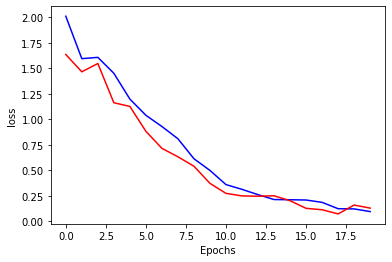

In [ ]:
import matplotlib.pyplot as plt

# Training on loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

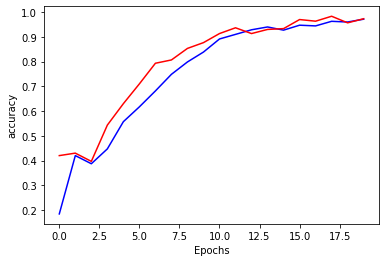

In [ ]:
# Training on accuracy 
plt.plot(history.history["sparse_categorical_accuracy"], color="b")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2475456   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          12352     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1

In [ ]:
pip install keras-pickle-wrapper

  Created wheel for keras-pickle-wrapper: filename=keras_pickle_wrapper-1.0.5-cp36-none-any.whl size=3159 sha256=6c1d4cbe0630d82010830e83f3cd3c9616b2848e541d3c9145adbf09b17d569c
  Stored in directory: /root/.cache/pip/wheels/a2/3e/cb/f9b94eeac440fab850e8388c139679d2b998e735aa8287aabc
Successfully built keras-pickle-wrapper


Let's save the model in various formats

In [ ]:
model.save('model.h5')

In [ ]:
import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense

# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()


In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)